## Imports

In [1]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
import math
import copy

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset
sys.path.insert(0, '../../Utils')

import models
from train import *
from metrics import * 
#from Gradient_Ascent import data_extraction
from skimage.restoration import denoise_nl_means, estimate_sigma

from PIL import Image
import pdb

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.7.2 (default, Feb 21 2019, 17:35:59) [MSC v.1915 64 bit (AMD64)]
Pytorch: 1.4.0+cu92


## Hyperparameters

In [2]:
n_epochs = 100
batch_size = 32
lr = 0.01

## Load ATT

In [18]:
data_dir = "..\\..\\attfaces\\s35"

img_paths = []
for p in os.listdir(data_dir): 
    #for i in os.listdir(os.path.join(data_dir,p)): 
    img_paths.append(os.path.join(data_dir,p))
        
people = []
people_to_idx = {}
k = 0 
for i in img_paths: 
    name = i.split('\\')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = k
        k += 1

img=Image.open(img_paths[0])
img.show()

10
tensor([0, 0, 0, 0, 0, 0, 0])
tensor(0.)
tensor(0.9490)
torch.Size([7, 1, 112, 92])


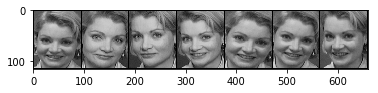

In [19]:
#img_paths = np.random.permutation(img_paths)

lfw_size = len(img_paths)

lfw_train_size = int(0.7 * lfw_size)

lfw_train_list = img_paths[:lfw_train_size]
lfw_test_list = img_paths[lfw_train_size:]
print(lfw_size)

class ATTdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        
        image = np.empty((112, 92, 1), dtype=np.uint8)
        img_path = self.file_list[idx]
        im = io.imread(img_path)
        im = im.reshape(112,92)
        image[:,:,0]= im
#         image[:,:,1]= im
#         image[:,:,2]= im
        # pdb.set_trace()
        label = self.people_to_idx[img_path.split('\\')[-2]]
        
        if self.transform is not None: 
            image = self.transform(image)
        
        return image, label
        

# Data augmentation 
train_transform = torchvision.transforms.Compose([

#     torchvision.transforms.ToPILImage(),
#     torchvision.transforms.CenterCrop((92,92)),    
#     torchvision.transforms.Resize((128,128)),
    torchvision.transforms.ToTensor(),

    
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
    

trainset = ATTdataset(lfw_train_list, people_to_idx, transform=train_transform)
testset = ATTdataset(lfw_test_list, people_to_idx, transform=test_transform)
sampleset = ATTdataset(lfw_test_list, people_to_idx, transform=torchvision.transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
sampleloader = torch.utils.data.DataLoader(sampleset, batch_size=1, shuffle=False, num_workers=0)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    #img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 
print(labels)
print(imgs.min())
print(imgs.max())
print(imgs.shape)

## Model Architecture

In [10]:
class mlp(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=3000): 
        super(mlp, self).__init__()
        
        self.hidden1 = nn.Linear(n_in, n_out)        

    def forward(self, x):

        x = x.view(-1,112*92)
        out = self.hidden1(x)
        return out

In [11]:
# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = mlp().to(device)
net.apply(models.weights_init)

net2 = mlp().to(device)
net2.apply(models.weights_init)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)


ww0 = copy.deepcopy(net2.hidden1.weight.data)
bb = copy.deepcopy(net2.hidden1.bias.data[:])
im0 = ww0[34].reshape(112,92)

## Training 

In [12]:
train(net, trainloader, testloader, optimizer, criterion, n_epochs, verbose=False)

[0/100]
Training:

Accuracy = 3.21 %


Test:

Accuracy = 0.83 %


[1/100]
Training:

Accuracy = 4.29 %


Test:

Accuracy = 1.67 %


[2/100]
Training:

Accuracy = 5.71 %


Test:

Accuracy = 5.83 %


[3/100]
Training:

Accuracy = 20.00 %


Test:

Accuracy = 15.00 %


[4/100]
Training:

Accuracy = 28.21 %


Test:

Accuracy = 21.67 %


[5/100]
Training:

Accuracy = 36.07 %


Test:

Accuracy = 18.33 %


[6/100]
Training:

Accuracy = 49.29 %


Test:

Accuracy = 37.50 %


[7/100]
Training:

Accuracy = 76.07 %


Test:

Accuracy = 55.83 %


[8/100]
Training:

Accuracy = 80.36 %


Test:

Accuracy = 63.33 %


[9/100]
Training:

Accuracy = 93.57 %


Test:

Accuracy = 73.33 %


[10/100]
Training:

Accuracy = 95.00 %


Test:

Accuracy = 76.67 %


[11/100]
Training:

Accuracy = 96.07 %


Test:

Accuracy = 80.83 %


[12/100]
Training:

Accuracy = 98.57 %


Test:

Accuracy = 82.50 %


[13/100]
Training:

Accuracy = 97.86 %


Test:

Accuracy = 89.17 %


[14/100]
Training:

Accuracy = 98.93 %


Test:

Ac

(100.0, 92.5)

In [13]:
train(net2, trainloader, testloader, optimizer2, criterion, n_epochs, verbose=False)

[0/100]
Training:

Accuracy = 25.00 %


Test:

Accuracy = 10.00 %


[1/100]
Training:

Accuracy = 16.79 %


Test:

Accuracy = 7.50 %


[2/100]
Training:

Accuracy = 50.36 %


Test:

Accuracy = 30.83 %


[3/100]
Training:

Accuracy = 49.64 %


Test:

Accuracy = 35.83 %


[4/100]
Training:

Accuracy = 71.07 %


Test:

Accuracy = 50.00 %


[5/100]
Training:

Accuracy = 85.71 %


Test:

Accuracy = 65.83 %


[6/100]
Training:

Accuracy = 93.21 %


Test:

Accuracy = 77.50 %


[7/100]
Training:

Accuracy = 87.86 %


Test:

Accuracy = 70.00 %


[8/100]
Training:

Accuracy = 96.79 %


Test:

Accuracy = 75.00 %


[9/100]
Training:

Accuracy = 98.57 %


Test:

Accuracy = 89.17 %


[10/100]
Training:

Accuracy = 95.71 %


Test:

Accuracy = 79.17 %


[11/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 91.67 %


[12/100]
Training:

Accuracy = 100.00 %


Test:

Accuracy = 95.00 %


[13/100]
Training:

Accuracy = 99.29 %


Test:

Accuracy = 88.33 %


[14/100]
Training:

Accuracy = 100.00 %


T

(100.0, 96.66666666666667)

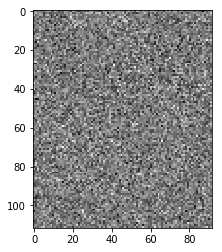

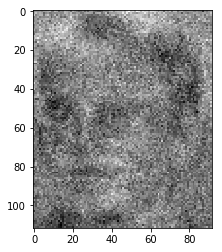

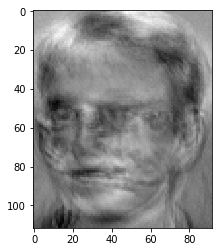

In [17]:
ww = net2.hidden1.weight.data[:]
bb = net2.hidden1.bias.data[:]

im_train = ww[34,:].squeeze().cpu().detach().numpy().reshape(112,92)
plt.imshow(im0.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

plt.imshow(im_train,cmap='gray')
plt.show()

plt.imshow(im_train-im0.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

# plt.imshow(im_train-torch.randn(im_train.shape)/100,cmap='gray')
# plt.show()
# # print(torch.sum())

## Gradient Ascent

In [18]:
from torch.autograd import Variable

def ga(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses = []
    grad0 = np.zeros((112,92))
    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            
#             out = nn.functional.softmax(net(input), dim=1)
            out = net(input)
            loss= -out.take(category)#+reg_alpha
            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        losses.append(loss.data)
#         print(j)
        grad0=input.grad.data.squeeze().cpu().detach().numpy()
        input.grad.data = input.grad.data - input.grad.data
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

In [19]:
from torch.autograd import Variable
def ga_adam(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses=[]

    v_x = torch.tensor(np.zeros((112,92))).unsqueeze(0).float().cuda()
    m_x = torch.tensor(np.zeros((112,92))).unsqueeze(0).float().cuda()
    beta1 = torch.tensor(0.9).cuda()
    beta2 = torch.tensor(0.99).cuda()
    eps = torch.tensor(1e-6).cuda()
    
    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            out = nn.functional.softmax(net(input), dim=1)
            loss= -out.take(category)#+reg_alpha
            
            loss.backward()
            
            m_x = beta1 *m_x + (1-beta1) * input.grad.data       
            v_x = beta2 *v_x + (1-beta2) * input.grad.data**2
            input.data = input.data - lr * m_x / torch.sqrt(v_x+eps)
            input.grad.zero_()
#             input.data = input.data - lr * input.grad.data
        print(j)
        print(loss.data)
        print(-out.take(category))
        losses.append(loss.data)
        plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray')
        plt.show()
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

In [ ]:
# import os
# import imageio

# png_dir = 'png/'
# images = []
# # for file_name in os.listdir(png_dir):
# for i in range(100):
#     filename = f"Results/2Fred {i}.png" 
# #     if file_name.endswith('dog_dream_%i.png' %(i)):
# #     file_path = os.path.join(png_dir, file_name)
#     images.append(imageio.imread(filename))
        
# kargs = { 'duration': 0.1 }
# imageio.mimsave('movie.gif', images,**kargs)

## Overfitted model

Gradient Ascent optimizes an input image to maximize the posterior of a particular category. 

Gradient Ascent reconstructs the memorized image within the parameters. If the model is well generalized with a lower learning rate and higher testing accuracy the method is not as effective. Although new results show that if the initial model parameters are subtracted from the reconstruction an accurate reconstruction will be generated.

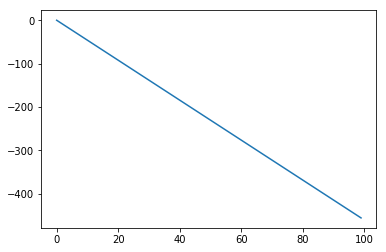

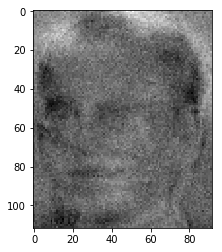

In [20]:

# np_page=np.random.random((112,92))
np_page=np.zeros((112,92))

dream_ga=ga(torch.Tensor((np_page)),net,100,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

## More generalized model

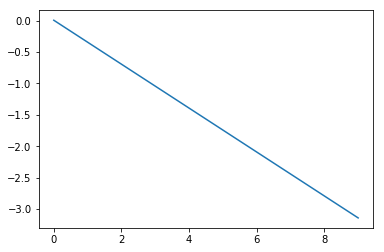

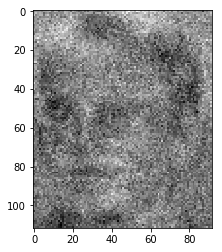

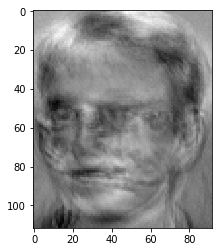

In [22]:
# np_page=np.random.random((112,92))
np_page=np.zeros((112,92))

dream_ga=ga(torch.Tensor((np_page)),net2,10,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
# plt.imsave("noisy.png",dream_ga.squeeze().cpu().detach().numpy(),cmap = 'gray',format='png')
# plt.imsave("noise.png",im0,cmap = 'gray',format='png')
# plt.imsave("noisy-noise.png",dream_ga.squeeze().cpu().detach().numpy()-im0,cmap = 'gray',format='png')
plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im0.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [ ]:
# # plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im0*.2253,cmap='gray')
# plt.imshow(dream_ga.mean().cpu().detach().numpy()-im_train*.2253,cmap='gray')
# print((dream_ga/im0).mean())
# # print((im0*dream_ga.mean().cpu().detach().numpy()/im0.mean()).mean())
# # print(dream_ga.squeeze().cpu().detach().numpy().mean())
# # print((dream_ga.mean().cpu().detach().numpy()/im_train).mean())
# plt.show()
# plt.imshow((dream_ga/im0).squeeze().cpu().detach().numpy(),vmin=100,vmax=1000)
# plt.show()

## Regularization

In [23]:
alpha_reg_alpha = 6
def alpha_norm(input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm


def ga_norm(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses=[]

    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            out = nn.functional.softmax(net(input), dim=1)
            reg_alpha = alpha_norm(input, alpha_reg_alpha)/1000
            loss= -out.take(category)+reg_alpha
            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        print(j)
        print(loss.data)
        print(-out.take(category))
        losses.append(loss.data)
        plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1)
        plt.show()
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

0
tensor([-0.0248], device='cuda:0')
tensor([-0.0248], device='cuda:0', grad_fn=<NegBackward>)


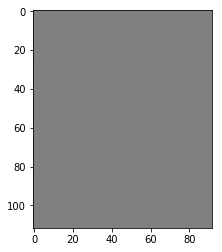

1
tensor([-0.0250], device='cuda:0')
tensor([-0.0250], device='cuda:0', grad_fn=<NegBackward>)


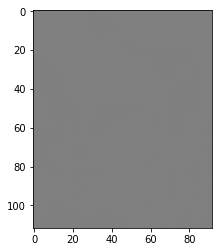

2
tensor([-0.0253], device='cuda:0')
tensor([-0.0253], device='cuda:0', grad_fn=<NegBackward>)


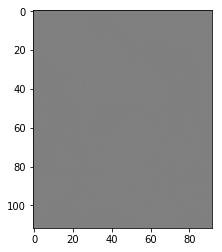

3
tensor([-0.0255], device='cuda:0')
tensor([-0.0255], device='cuda:0', grad_fn=<NegBackward>)


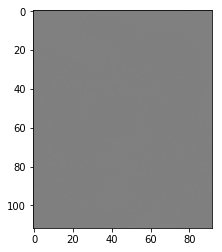

4
tensor([-0.0257], device='cuda:0')
tensor([-0.0257], device='cuda:0', grad_fn=<NegBackward>)


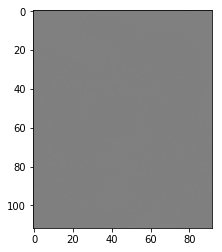

5
tensor([-0.0259], device='cuda:0')
tensor([-0.0259], device='cuda:0', grad_fn=<NegBackward>)


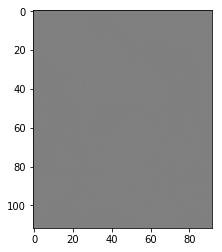

6
tensor([-0.0262], device='cuda:0')
tensor([-0.0262], device='cuda:0', grad_fn=<NegBackward>)


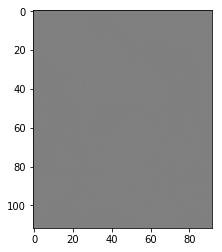

7
tensor([-0.0264], device='cuda:0')
tensor([-0.0264], device='cuda:0', grad_fn=<NegBackward>)


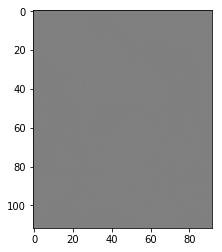

8
tensor([-0.0266], device='cuda:0')
tensor([-0.0266], device='cuda:0', grad_fn=<NegBackward>)


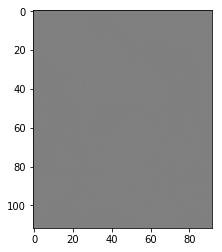

9
tensor([-0.0269], device='cuda:0')
tensor([-0.0269], device='cuda:0', grad_fn=<NegBackward>)


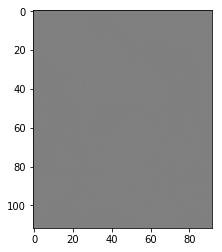

10
tensor([-0.0271], device='cuda:0')
tensor([-0.0271], device='cuda:0', grad_fn=<NegBackward>)


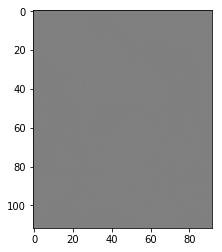

11
tensor([-0.0274], device='cuda:0')
tensor([-0.0274], device='cuda:0', grad_fn=<NegBackward>)


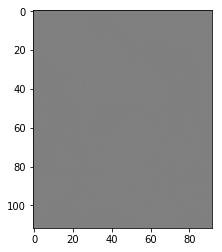

12
tensor([-0.0277], device='cuda:0')
tensor([-0.0277], device='cuda:0', grad_fn=<NegBackward>)


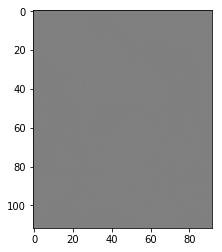

13
tensor([-0.0279], device='cuda:0')
tensor([-0.0279], device='cuda:0', grad_fn=<NegBackward>)


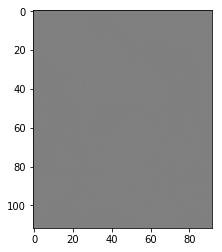

14
tensor([-0.0282], device='cuda:0')
tensor([-0.0282], device='cuda:0', grad_fn=<NegBackward>)


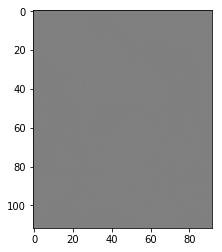

15
tensor([-0.0285], device='cuda:0')
tensor([-0.0285], device='cuda:0', grad_fn=<NegBackward>)


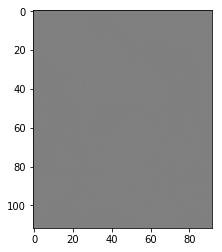

16
tensor([-0.0287], device='cuda:0')
tensor([-0.0287], device='cuda:0', grad_fn=<NegBackward>)


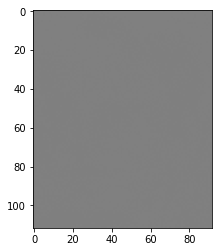

17
tensor([-0.0290], device='cuda:0')
tensor([-0.0290], device='cuda:0', grad_fn=<NegBackward>)


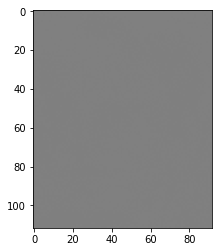

18
tensor([-0.0293], device='cuda:0')
tensor([-0.0293], device='cuda:0', grad_fn=<NegBackward>)


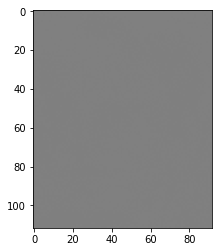

19
tensor([-0.0296], device='cuda:0')
tensor([-0.0296], device='cuda:0', grad_fn=<NegBackward>)


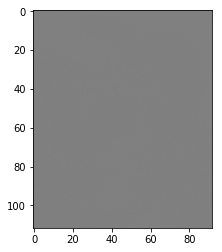

20
tensor([-0.0299], device='cuda:0')
tensor([-0.0299], device='cuda:0', grad_fn=<NegBackward>)


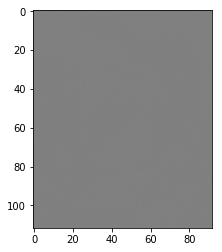

21
tensor([-0.0302], device='cuda:0')
tensor([-0.0302], device='cuda:0', grad_fn=<NegBackward>)


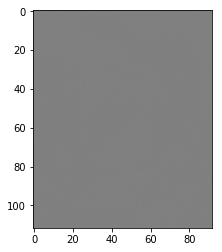

22
tensor([-0.0305], device='cuda:0')
tensor([-0.0305], device='cuda:0', grad_fn=<NegBackward>)


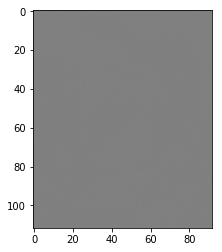

23
tensor([-0.0309], device='cuda:0')
tensor([-0.0309], device='cuda:0', grad_fn=<NegBackward>)


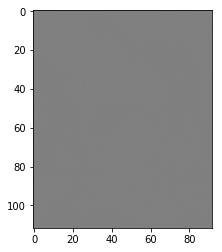

24
tensor([-0.0312], device='cuda:0')
tensor([-0.0312], device='cuda:0', grad_fn=<NegBackward>)


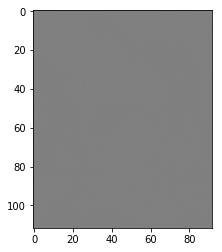

25
tensor([-0.0315], device='cuda:0')
tensor([-0.0315], device='cuda:0', grad_fn=<NegBackward>)


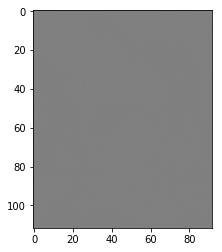

26
tensor([-0.0319], device='cuda:0')
tensor([-0.0319], device='cuda:0', grad_fn=<NegBackward>)


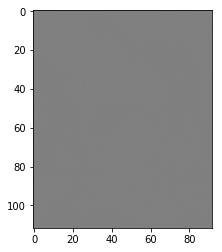

27
tensor([-0.0322], device='cuda:0')
tensor([-0.0322], device='cuda:0', grad_fn=<NegBackward>)


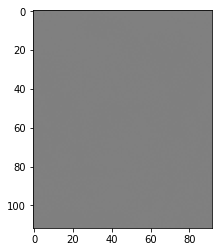

28
tensor([-0.0326], device='cuda:0')
tensor([-0.0326], device='cuda:0', grad_fn=<NegBackward>)


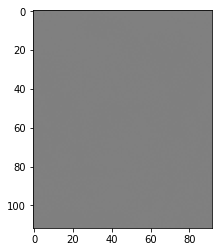

29
tensor([-0.0329], device='cuda:0')
tensor([-0.0329], device='cuda:0', grad_fn=<NegBackward>)


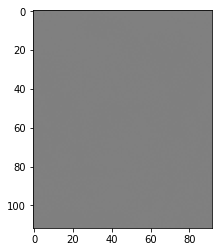

30
tensor([-0.0333], device='cuda:0')
tensor([-0.0333], device='cuda:0', grad_fn=<NegBackward>)


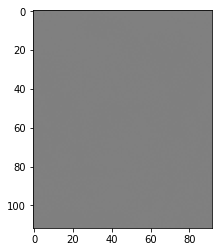

31
tensor([-0.0337], device='cuda:0')
tensor([-0.0337], device='cuda:0', grad_fn=<NegBackward>)


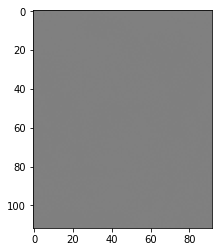

32
tensor([-0.0340], device='cuda:0')
tensor([-0.0340], device='cuda:0', grad_fn=<NegBackward>)


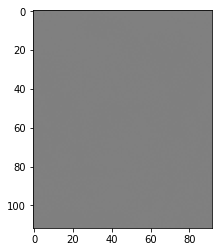

33
tensor([-0.0344], device='cuda:0')
tensor([-0.0344], device='cuda:0', grad_fn=<NegBackward>)


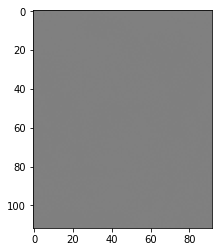

34
tensor([-0.0348], device='cuda:0')
tensor([-0.0348], device='cuda:0', grad_fn=<NegBackward>)


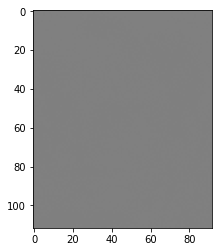

35
tensor([-0.0353], device='cuda:0')
tensor([-0.0353], device='cuda:0', grad_fn=<NegBackward>)


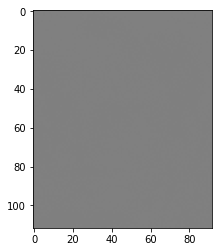

36
tensor([-0.0357], device='cuda:0')
tensor([-0.0357], device='cuda:0', grad_fn=<NegBackward>)


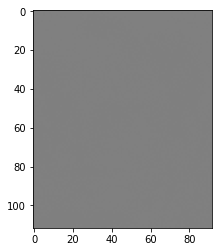

37
tensor([-0.0361], device='cuda:0')
tensor([-0.0361], device='cuda:0', grad_fn=<NegBackward>)


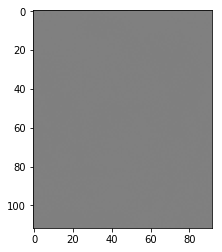

38
tensor([-0.0366], device='cuda:0')
tensor([-0.0366], device='cuda:0', grad_fn=<NegBackward>)


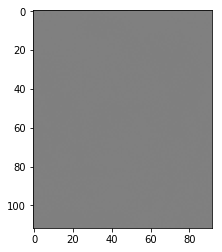

39
tensor([-0.0370], device='cuda:0')
tensor([-0.0370], device='cuda:0', grad_fn=<NegBackward>)


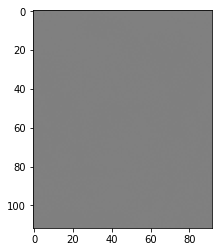

40
tensor([-0.0375], device='cuda:0')
tensor([-0.0375], device='cuda:0', grad_fn=<NegBackward>)


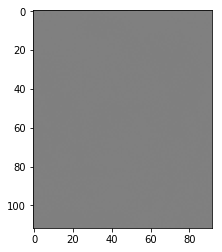

41
tensor([-0.0379], device='cuda:0')
tensor([-0.0379], device='cuda:0', grad_fn=<NegBackward>)


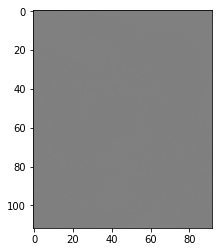

42
tensor([-0.0384], device='cuda:0')
tensor([-0.0384], device='cuda:0', grad_fn=<NegBackward>)


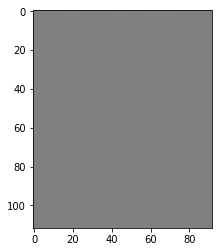

43
tensor([-0.0389], device='cuda:0')
tensor([-0.0389], device='cuda:0', grad_fn=<NegBackward>)


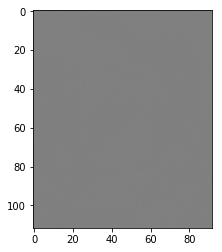

44
tensor([-0.0394], device='cuda:0')
tensor([-0.0394], device='cuda:0', grad_fn=<NegBackward>)


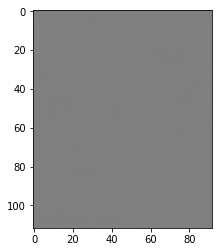

45
tensor([-0.0400], device='cuda:0')
tensor([-0.0400], device='cuda:0', grad_fn=<NegBackward>)


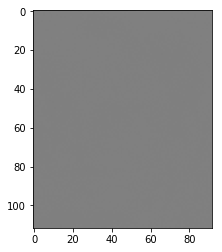

46
tensor([-0.0405], device='cuda:0')
tensor([-0.0405], device='cuda:0', grad_fn=<NegBackward>)


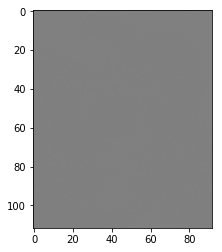

47
tensor([-0.0411], device='cuda:0')
tensor([-0.0411], device='cuda:0', grad_fn=<NegBackward>)


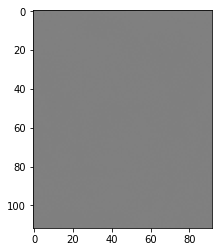

48
tensor([-0.0416], device='cuda:0')
tensor([-0.0416], device='cuda:0', grad_fn=<NegBackward>)


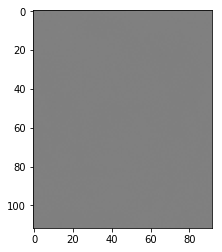

49
tensor([-0.0422], device='cuda:0')
tensor([-0.0422], device='cuda:0', grad_fn=<NegBackward>)


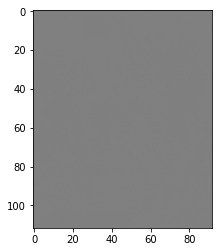

50
tensor([-0.0428], device='cuda:0')
tensor([-0.0428], device='cuda:0', grad_fn=<NegBackward>)


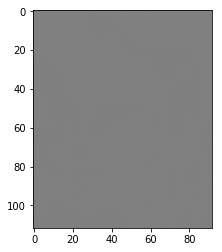

51
tensor([-0.0434], device='cuda:0')
tensor([-0.0434], device='cuda:0', grad_fn=<NegBackward>)


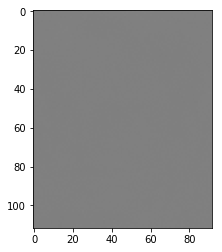

52
tensor([-0.0440], device='cuda:0')
tensor([-0.0440], device='cuda:0', grad_fn=<NegBackward>)


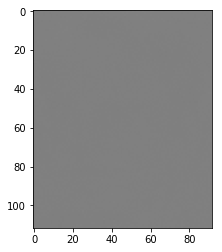

53
tensor([-0.0447], device='cuda:0')
tensor([-0.0447], device='cuda:0', grad_fn=<NegBackward>)


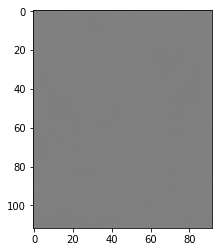

54
tensor([-0.0454], device='cuda:0')
tensor([-0.0454], device='cuda:0', grad_fn=<NegBackward>)


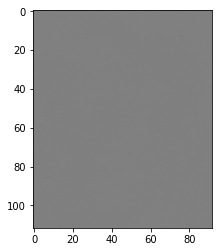

55
tensor([-0.0460], device='cuda:0')
tensor([-0.0460], device='cuda:0', grad_fn=<NegBackward>)


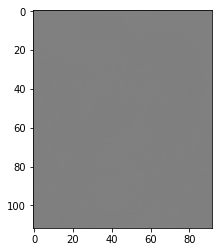

56
tensor([-0.0467], device='cuda:0')
tensor([-0.0467], device='cuda:0', grad_fn=<NegBackward>)


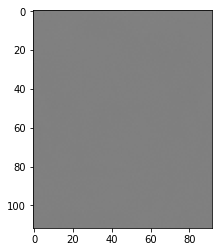

57
tensor([-0.0475], device='cuda:0')
tensor([-0.0475], device='cuda:0', grad_fn=<NegBackward>)


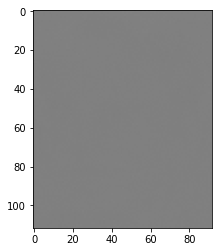

58
tensor([-0.0482], device='cuda:0')
tensor([-0.0482], device='cuda:0', grad_fn=<NegBackward>)


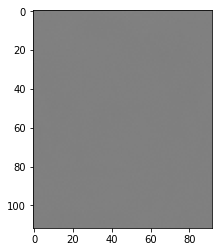

59
tensor([-0.0490], device='cuda:0')
tensor([-0.0490], device='cuda:0', grad_fn=<NegBackward>)


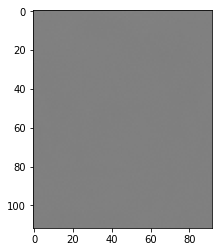

60
tensor([-0.0498], device='cuda:0')
tensor([-0.0498], device='cuda:0', grad_fn=<NegBackward>)


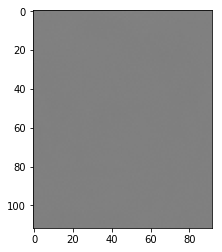

61
tensor([-0.0506], device='cuda:0')
tensor([-0.0506], device='cuda:0', grad_fn=<NegBackward>)


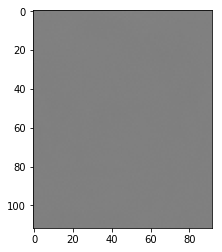

62
tensor([-0.0514], device='cuda:0')
tensor([-0.0514], device='cuda:0', grad_fn=<NegBackward>)


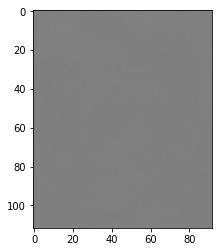

63
tensor([-0.0523], device='cuda:0')
tensor([-0.0523], device='cuda:0', grad_fn=<NegBackward>)


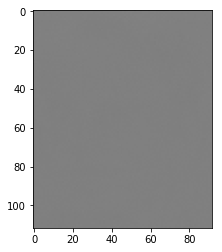

64
tensor([-0.0532], device='cuda:0')
tensor([-0.0532], device='cuda:0', grad_fn=<NegBackward>)


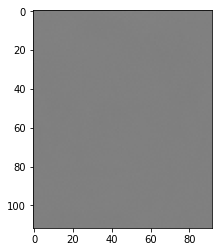

65
tensor([-0.0541], device='cuda:0')
tensor([-0.0541], device='cuda:0', grad_fn=<NegBackward>)


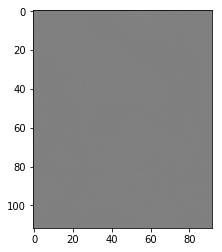

66
tensor([-0.0551], device='cuda:0')
tensor([-0.0551], device='cuda:0', grad_fn=<NegBackward>)


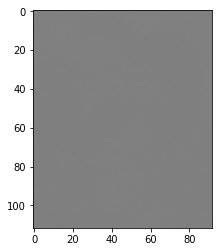

67
tensor([-0.0561], device='cuda:0')
tensor([-0.0561], device='cuda:0', grad_fn=<NegBackward>)


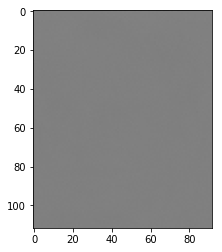

68
tensor([-0.0571], device='cuda:0')
tensor([-0.0571], device='cuda:0', grad_fn=<NegBackward>)


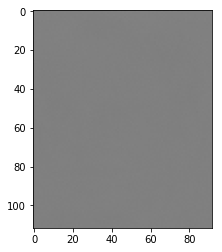

69
tensor([-0.0581], device='cuda:0')
tensor([-0.0581], device='cuda:0', grad_fn=<NegBackward>)


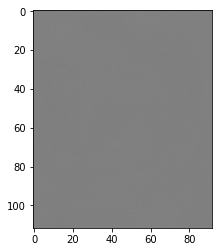

70
tensor([-0.0592], device='cuda:0')
tensor([-0.0592], device='cuda:0', grad_fn=<NegBackward>)


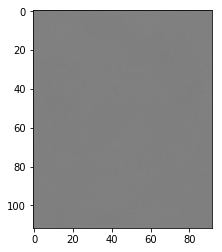

71
tensor([-0.0604], device='cuda:0')
tensor([-0.0604], device='cuda:0', grad_fn=<NegBackward>)


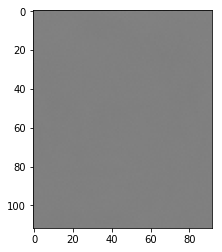

72
tensor([-0.0615], device='cuda:0')
tensor([-0.0615], device='cuda:0', grad_fn=<NegBackward>)


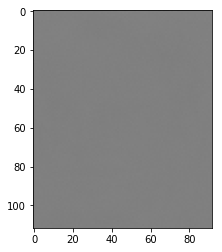

73
tensor([-0.0628], device='cuda:0')
tensor([-0.0628], device='cuda:0', grad_fn=<NegBackward>)


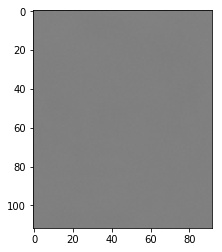

74
tensor([-0.0640], device='cuda:0')
tensor([-0.0640], device='cuda:0', grad_fn=<NegBackward>)


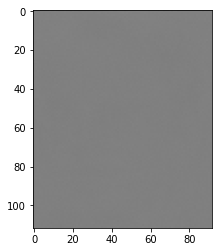

75
tensor([-0.0653], device='cuda:0')
tensor([-0.0653], device='cuda:0', grad_fn=<NegBackward>)


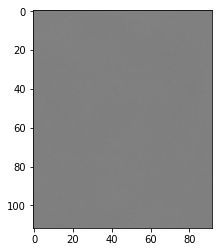

76
tensor([-0.0667], device='cuda:0')
tensor([-0.0667], device='cuda:0', grad_fn=<NegBackward>)


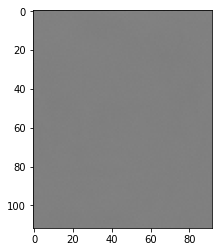

77
tensor([-0.0681], device='cuda:0')
tensor([-0.0681], device='cuda:0', grad_fn=<NegBackward>)


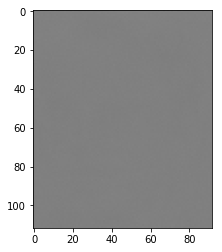

78
tensor([-0.0696], device='cuda:0')
tensor([-0.0696], device='cuda:0', grad_fn=<NegBackward>)


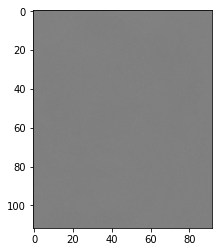

79
tensor([-0.0711], device='cuda:0')
tensor([-0.0711], device='cuda:0', grad_fn=<NegBackward>)


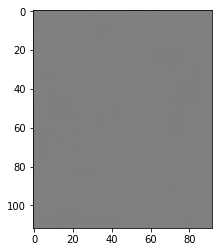

80
tensor([-0.0727], device='cuda:0')
tensor([-0.0727], device='cuda:0', grad_fn=<NegBackward>)


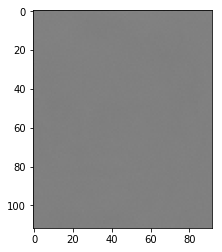

81
tensor([-0.0743], device='cuda:0')
tensor([-0.0743], device='cuda:0', grad_fn=<NegBackward>)


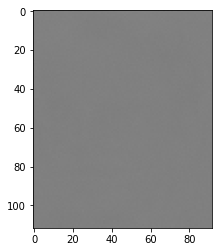

82
tensor([-0.0761], device='cuda:0')
tensor([-0.0761], device='cuda:0', grad_fn=<NegBackward>)


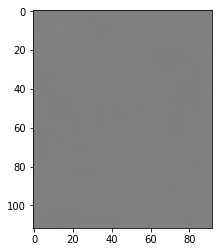

83
tensor([-0.0779], device='cuda:0')
tensor([-0.0779], device='cuda:0', grad_fn=<NegBackward>)


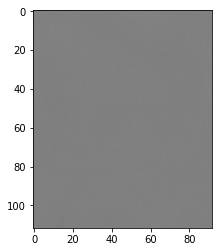

84
tensor([-0.0798], device='cuda:0')
tensor([-0.0798], device='cuda:0', grad_fn=<NegBackward>)


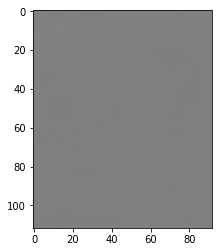

85
tensor([-0.0817], device='cuda:0')
tensor([-0.0817], device='cuda:0', grad_fn=<NegBackward>)


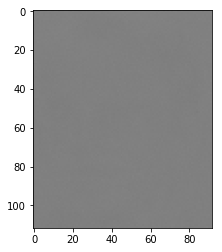

86
tensor([-0.0838], device='cuda:0')
tensor([-0.0838], device='cuda:0', grad_fn=<NegBackward>)


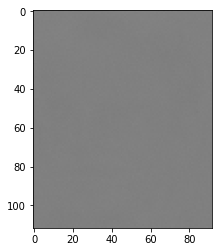

87
tensor([-0.0859], device='cuda:0')
tensor([-0.0859], device='cuda:0', grad_fn=<NegBackward>)


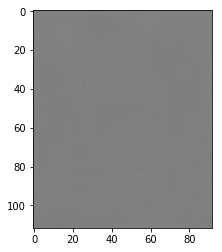

88
tensor([-0.0882], device='cuda:0')
tensor([-0.0882], device='cuda:0', grad_fn=<NegBackward>)


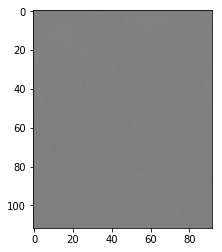

89
tensor([-0.0905], device='cuda:0')
tensor([-0.0905], device='cuda:0', grad_fn=<NegBackward>)


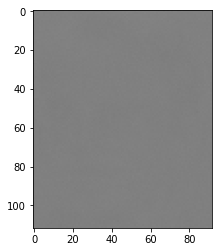

90
tensor([-0.0930], device='cuda:0')
tensor([-0.0930], device='cuda:0', grad_fn=<NegBackward>)


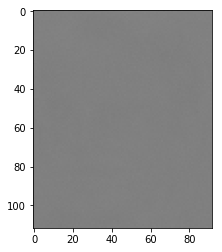

91
tensor([-0.0956], device='cuda:0')
tensor([-0.0956], device='cuda:0', grad_fn=<NegBackward>)


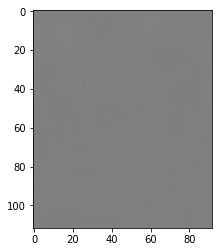

92
tensor([-0.0983], device='cuda:0')
tensor([-0.0983], device='cuda:0', grad_fn=<NegBackward>)


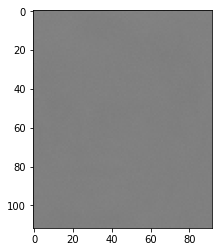

93
tensor([-0.1012], device='cuda:0')
tensor([-0.1012], device='cuda:0', grad_fn=<NegBackward>)


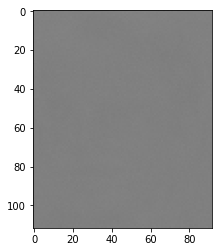

94
tensor([-0.1042], device='cuda:0')
tensor([-0.1042], device='cuda:0', grad_fn=<NegBackward>)


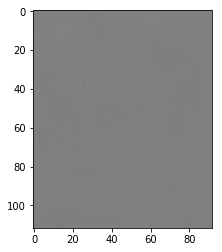

95
tensor([-0.1074], device='cuda:0')
tensor([-0.1074], device='cuda:0', grad_fn=<NegBackward>)


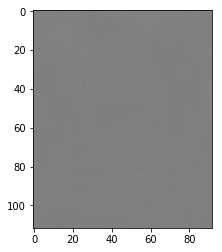

96
tensor([-0.1108], device='cuda:0')
tensor([-0.1108], device='cuda:0', grad_fn=<NegBackward>)


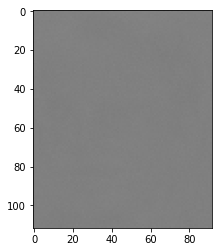

97
tensor([-0.1143], device='cuda:0')
tensor([-0.1143], device='cuda:0', grad_fn=<NegBackward>)


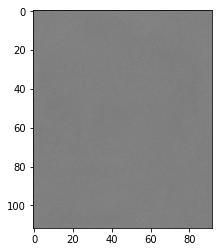

98
tensor([-0.1181], device='cuda:0')
tensor([-0.1181], device='cuda:0', grad_fn=<NegBackward>)


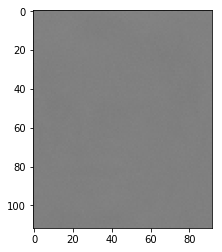

99
tensor([-0.1220], device='cuda:0')
tensor([-0.1220], device='cuda:0', grad_fn=<NegBackward>)


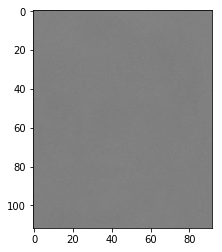

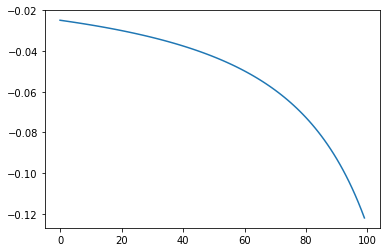

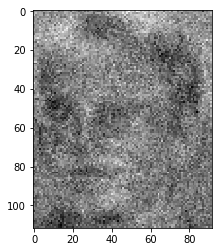

In [24]:
np_page=np.zeros((112,92))

dream_ga=ga_norm(torch.Tensor((np_page)),net2,100,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

## Auto-Encoder

Auto-encoder uses the target model as the encoder and inverts it to create the decoder. Overall reconstructs the same thing as GA but does it in 1 pass.

TODO: train decoder with shadow images.

In [25]:
class ae(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=3000): 
        super(ae, self).__init__()
        
        self.hidden1 = nn.Linear(n_in, n_out)        
        self.hidden2 = nn.Linear(n_out, n_in)
    def forward(self, x):
        x = x.view(-1,112*92)

        x = self.hidden1(x)
        out = self.hidden2(x)
        
        return out
    
class de(nn.Module): 
    def __init__(self, n_in=40, n_out=112*92, n_hidden=3000): 
        super(de, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_out)        
        
    def forward(self, x):
        x = x.view(-1,40)
        out = self.hidden1(x)
        
        return out

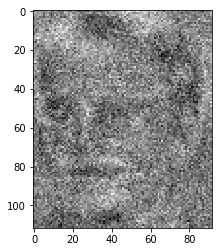

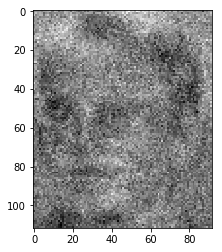

In [27]:
netAE = ae().to(device)
netDE = de().to(device)
ainv = np.linalg.pinv(net2.hidden1.weight.data.squeeze().cpu().detach().numpy())

netAE.hidden1.weight.data = net2.hidden1.weight.data
netAE.hidden2.weight.data = torch.tensor(ainv).to(device)
netDE.hidden1.weight.data = torch.tensor(ainv).to(device)

netAE.hidden1.bias.data = torch.tensor(0.0).to(device)
netAE.hidden2.bias.data = torch.tensor(0.0).to(device)
netDE.hidden1.bias.data = torch.tensor(0.0).to(device)

ww = net2.hidden1.weight.data
bb = net2.hidden1.bias.data

im = ww[34,:].squeeze().cpu().detach().numpy().reshape(112,92)

imAE = netAE(ww[34,:].to(device))

label = torch.zeros(40)
label[34]=1
imDE = netDE(label.to(device))


plt.imshow(imDE.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

plt.imshow(imAE.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

## Posterior Averaging

Posterior averaging works by taking a weighted average of a sample of images weghing it by the posterior activation of a particular category. 
Works well but depends on the information that you already have in your sample images

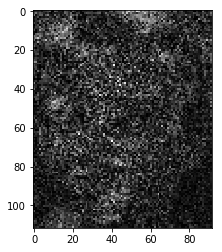

In [28]:
out_sum = torch.cuda.FloatTensor(np.zeros((1,112,92)))
n = torch.cuda.FloatTensor(np.zeros((1)))
# for j in range(100):
for i, batch in enumerate(testloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)

    out = nn.functional.softmax(net2(imgs), dim = 1 )
    out_im=(imgs*torch.tensor(np.abs(im)).to(device))

    out_sum =  (out_sum * n + torch.sum(out_im*out[:,34].view(-1,1,1,1),dim=0)) / (n + (imgs.size()[0]))
    n = n + (imgs.size()[0])
plt.imshow(out_sum.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

You can also just use the weighted average of the sample images weighted by the posterior probablity and not including the activation weighting. This works better for good sample images.

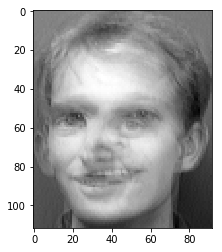

In [29]:

out_sum = torch.cuda.FloatTensor(np.zeros((1,112,92)))
n = torch.cuda.FloatTensor(np.zeros((1)))
# for j in range(100):
for i, batch in enumerate(testloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)

    out = nn.functional.softmax(net2(imgs), dim = 1 )
    out_im=(imgs).to(device)

    out_sum =  (out_sum * n + torch.sum(out_im*out[:,34].view(-1,1,1,1),dim=0)) / (n + (imgs.size()[0]))
    n = n + (imgs.size()[0])
plt.imshow(out_sum.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

## Student-teacher

In [30]:
student = mlp().to(device)
student.apply(models.weights_init)

ww_student = copy.deepcopy(student.hidden1.weight.data)
bb_student = copy.deepcopy(student.hidden1.bias.data[:])
im_student = ww_student[34].reshape(112,92)

criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student.parameters(), lr=lr/10)

In [31]:
def train_student(student, teacher, data_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
    losses = []
    train_accuracy = []
        
    for epoch in range(n_epochs):
        student.train()
        teacher.eval()
        net2.hidden1.weight.requires_grad=False
        total = 0
        correct = 0
        for i, batch in enumerate(data_loader):

            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            
#             imgs = torch.randn(imgs.size()).to(device)
#             im = torch.zeros(imgs.size())
#             for i in range(imgs.size(0)):
#                 imgs[i,0,:,:] = tensorBlur(imgs[i,:,:,:].squeeze(),15)
            optimizer.zero_grad()

            outputs = student(imgs)
            output_teacher = teacher(imgs).detach()
            
            ## accuracy calc
            predicted = outputs.argmax(dim=1)
            total += imgs.size(0)
            correct += predicted.eq(labels).sum().item()
            ##

#             loss = criterion(outputs, labels)
            loss = criterion(outputs, output_teacher)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if verbose:
                print("[%d/%d][%d/%d] loss = %f" % (epoch, n_epochs, i, len(data_loader), loss.item()))

        # evaluate performance on testset at the end of each epoch
        print("[%d/%d]" %(epoch, n_epochs))
#         train_accuracy.append(eval_target_net(net, data_loader, classes=classes))
        train_accuracy.append(correct/total*100)
#         test_accuracy.append(eval_target_net(net, test_loader, classes=classes))
        print("Train Accuracy %f" %(correct/total*100))
#         print(train_accuracy)
#         plt.plot(train_accuracy,'bo-',label="train accuracy")
        plt.plot(losses,'bo-',label="losses")
#         plt.plot(test_accuracy,'ro-',label="validation accuracy")
        
        # Place a legend to the right of this smaller subplot.
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        plt.show()

[0/100]
Train Accuracy 5.000000


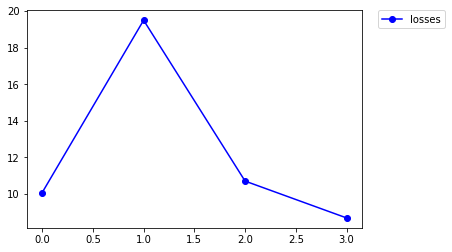

[1/100]
Train Accuracy 6.666667


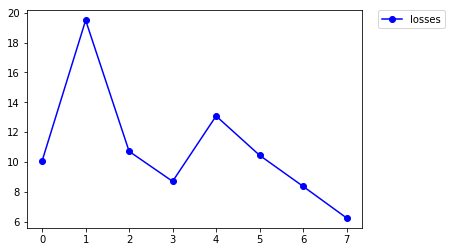

[2/100]
Train Accuracy 15.833333


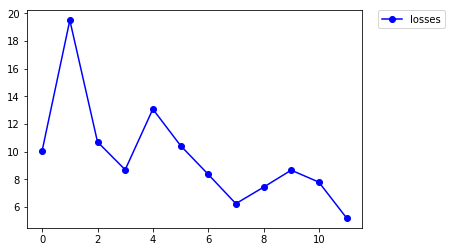

[3/100]
Train Accuracy 29.166667


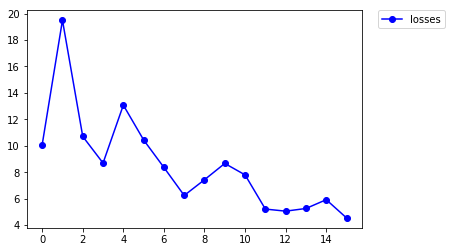

[4/100]
Train Accuracy 35.833333


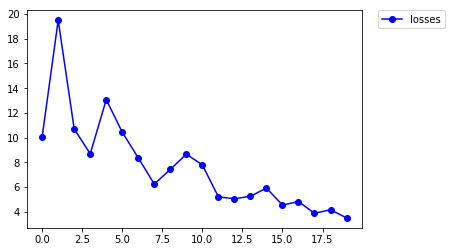

[5/100]
Train Accuracy 55.000000


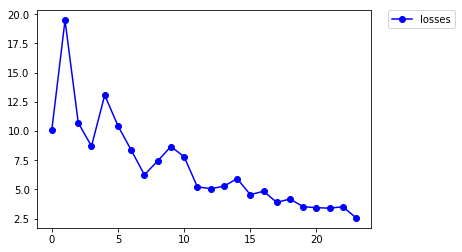

[6/100]
Train Accuracy 46.666667


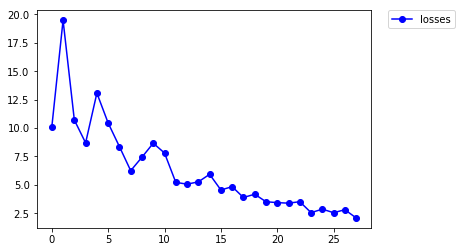

[7/100]
Train Accuracy 62.500000


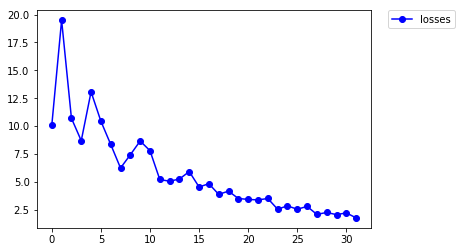

[8/100]
Train Accuracy 66.666667


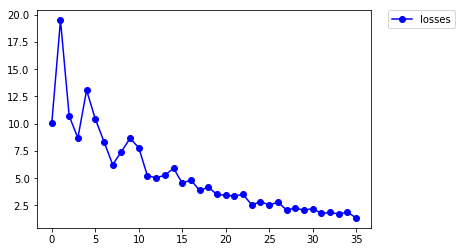

[9/100]
Train Accuracy 70.833333


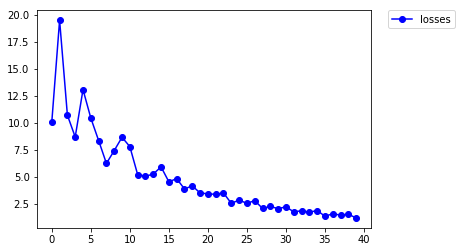

[10/100]
Train Accuracy 80.833333


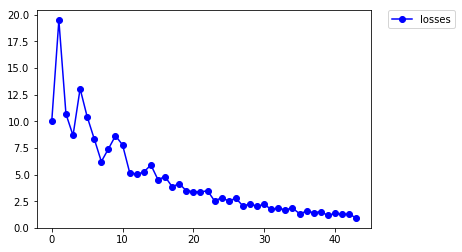

[11/100]
Train Accuracy 80.833333


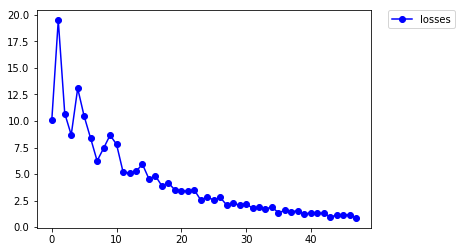

[12/100]
Train Accuracy 82.500000


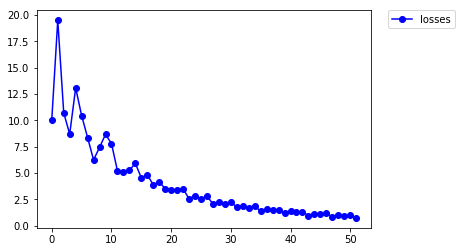

[13/100]
Train Accuracy 84.166667


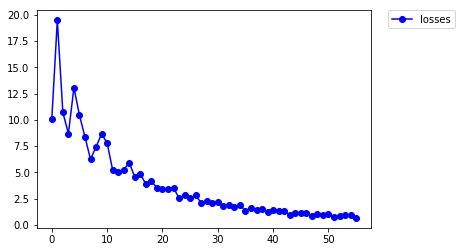

[14/100]
Train Accuracy 87.500000


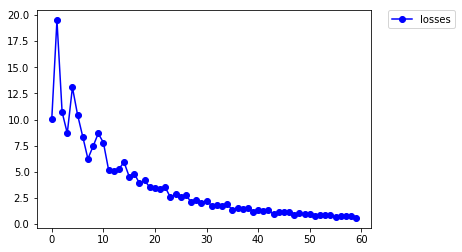

[15/100]
Train Accuracy 90.000000


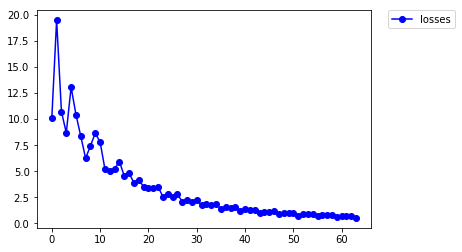

[16/100]
Train Accuracy 92.500000


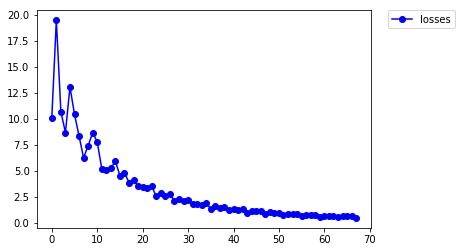

[17/100]
Train Accuracy 93.333333


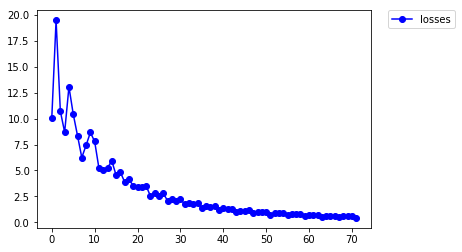

[18/100]
Train Accuracy 93.333333


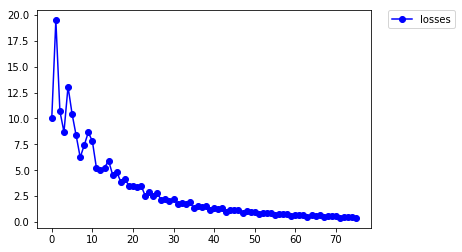

[19/100]
Train Accuracy 94.166667


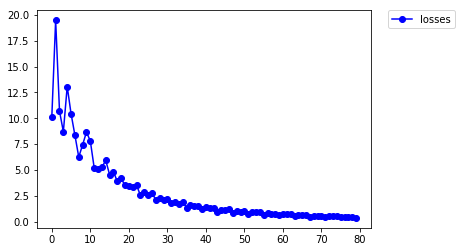

[20/100]
Train Accuracy 94.166667


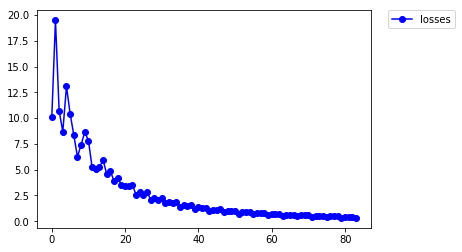

[21/100]
Train Accuracy 94.166667


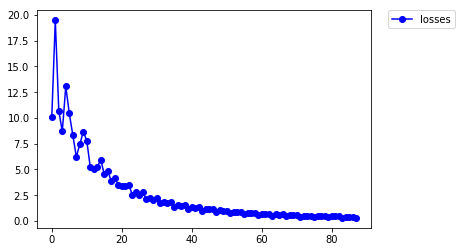

[22/100]
Train Accuracy 94.166667


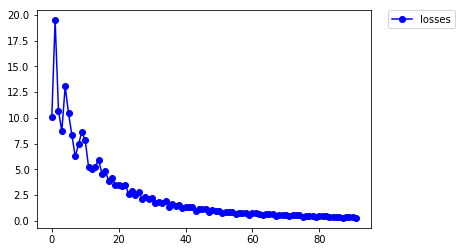

[23/100]
Train Accuracy 94.166667


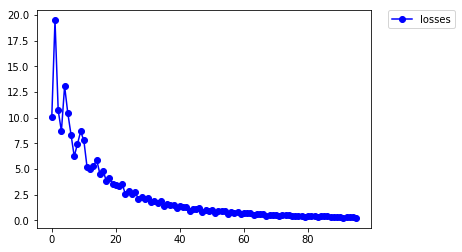

[24/100]
Train Accuracy 94.166667


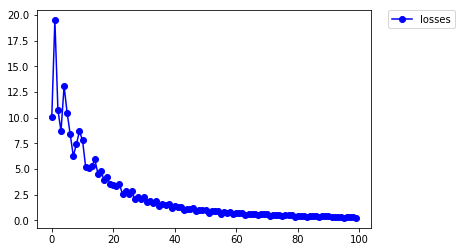

[25/100]
Train Accuracy 94.166667


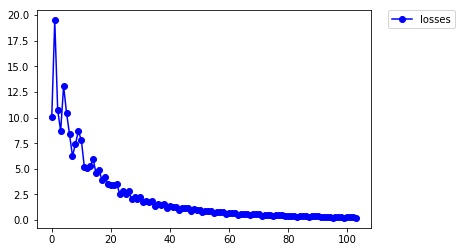

[26/100]
Train Accuracy 94.166667


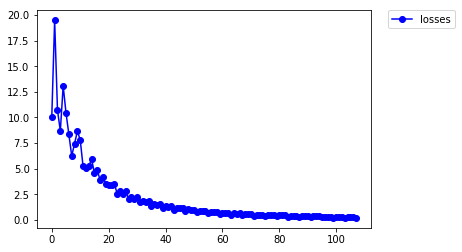

[27/100]
Train Accuracy 95.000000


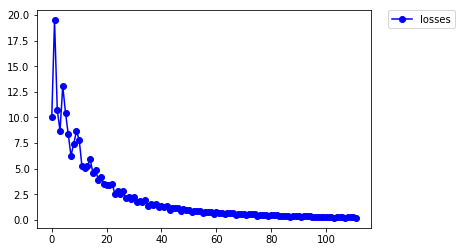

[28/100]
Train Accuracy 95.000000


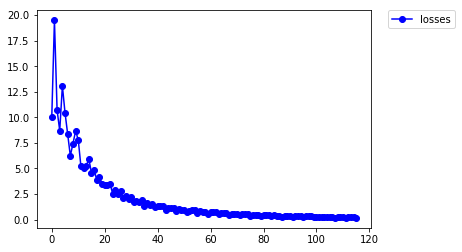

[29/100]
Train Accuracy 95.000000


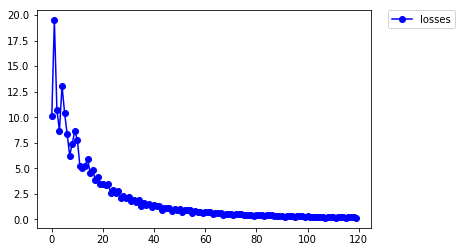

[30/100]
Train Accuracy 95.000000


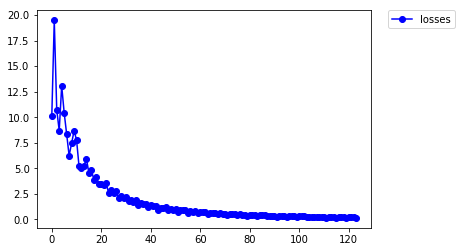

[31/100]
Train Accuracy 95.000000


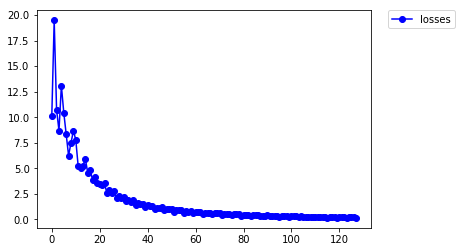

[32/100]
Train Accuracy 95.000000


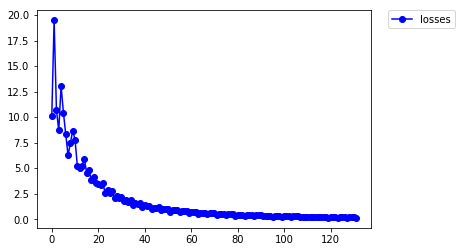

[33/100]
Train Accuracy 95.000000


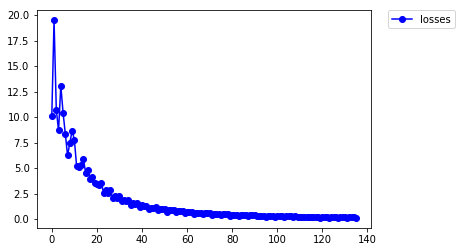

[34/100]
Train Accuracy 95.000000


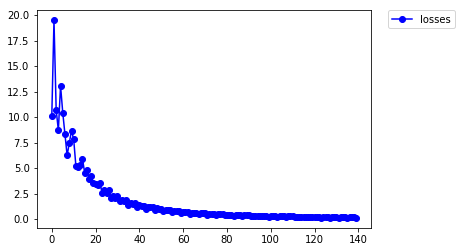

[35/100]
Train Accuracy 95.000000


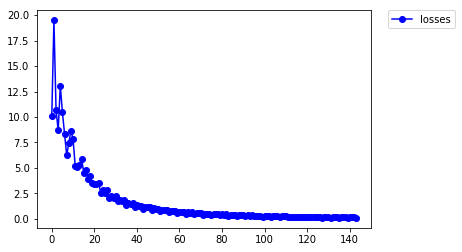

[36/100]
Train Accuracy 95.000000


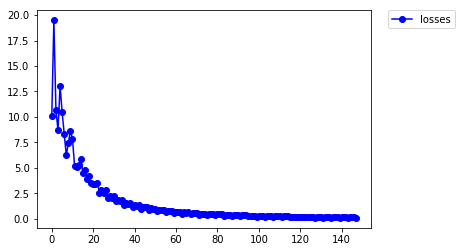

[37/100]
Train Accuracy 95.000000


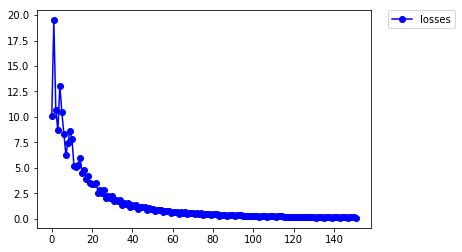

[38/100]
Train Accuracy 95.000000


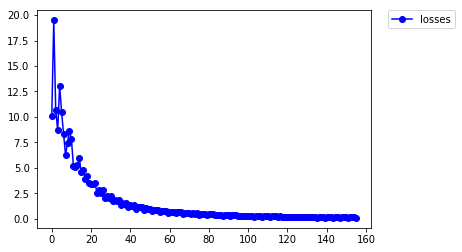

[39/100]
Train Accuracy 95.000000


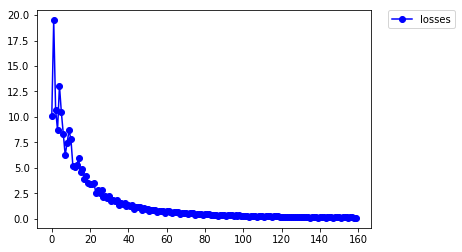

[40/100]
Train Accuracy 95.833333


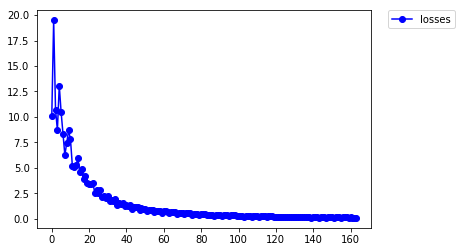

[41/100]
Train Accuracy 95.833333


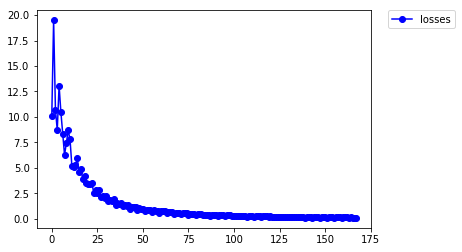

[42/100]
Train Accuracy 95.833333


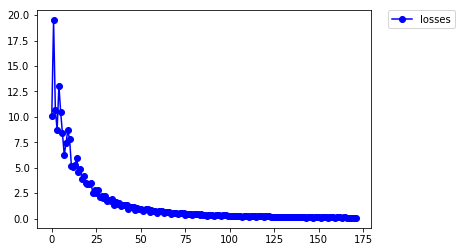

[43/100]
Train Accuracy 95.833333


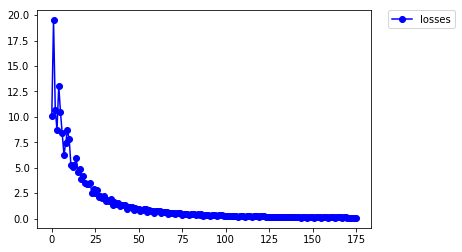

[44/100]
Train Accuracy 95.833333


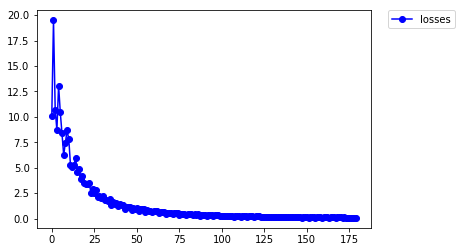

[45/100]
Train Accuracy 95.833333


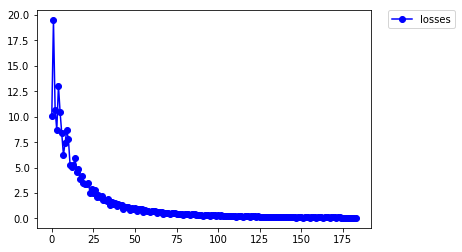

[46/100]
Train Accuracy 95.833333


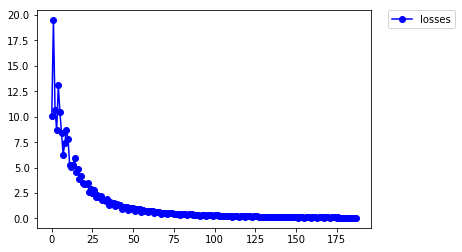

[47/100]
Train Accuracy 95.833333


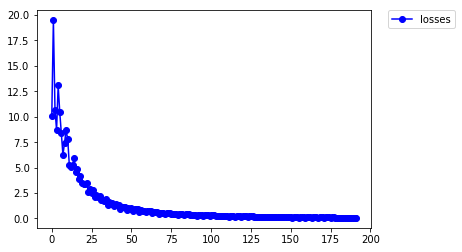

[48/100]
Train Accuracy 95.833333


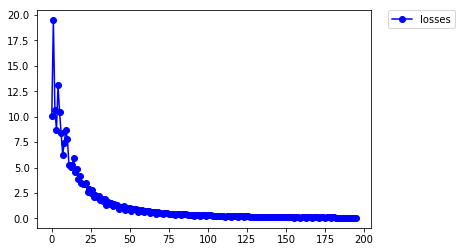

[49/100]
Train Accuracy 95.833333


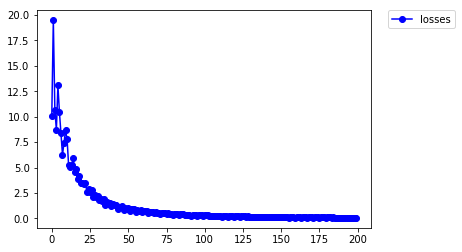

[50/100]
Train Accuracy 95.833333


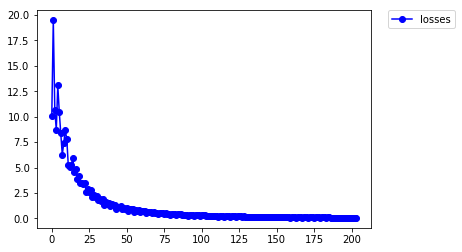

[51/100]
Train Accuracy 95.833333


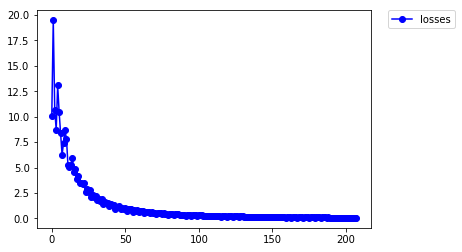

[52/100]
Train Accuracy 95.833333


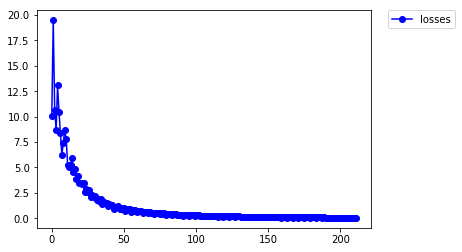

[53/100]
Train Accuracy 95.833333


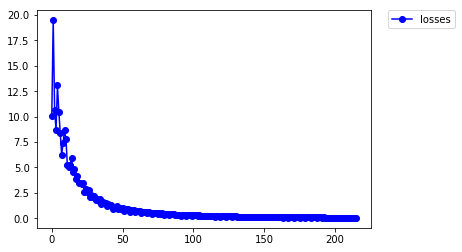

[54/100]
Train Accuracy 95.833333


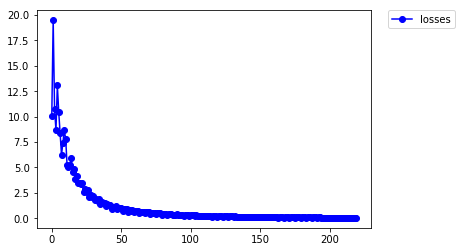

[55/100]
Train Accuracy 95.833333


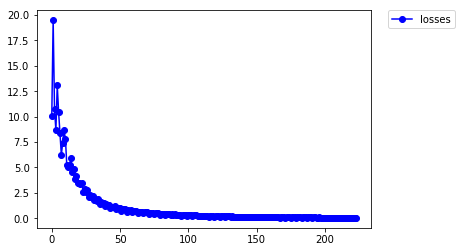

[56/100]
Train Accuracy 95.833333


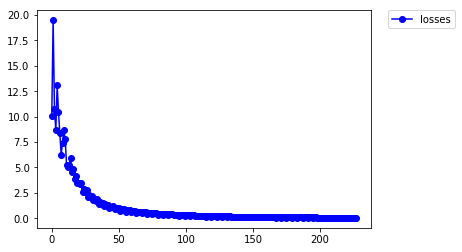

[57/100]
Train Accuracy 95.833333


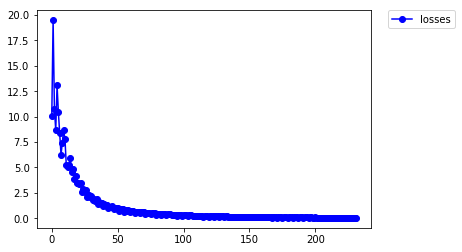

[58/100]
Train Accuracy 95.833333


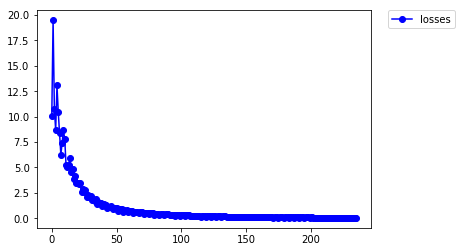

[59/100]
Train Accuracy 95.833333


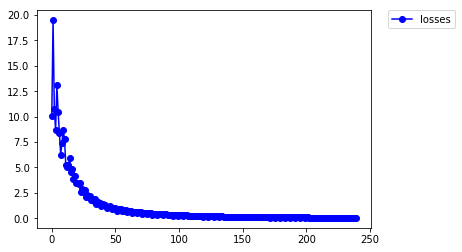

[60/100]
Train Accuracy 95.833333


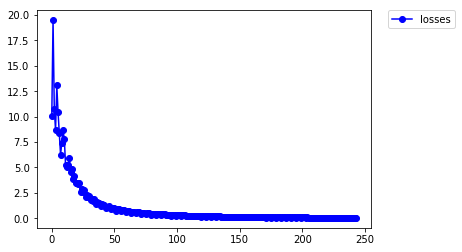

[61/100]
Train Accuracy 95.833333


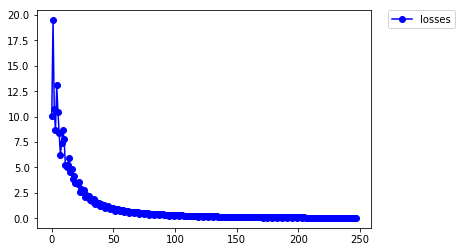

[62/100]
Train Accuracy 95.833333


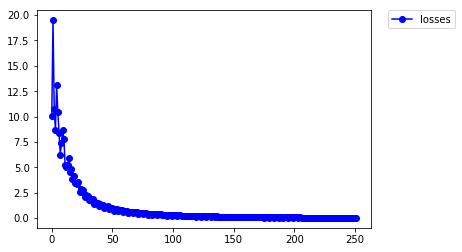

[63/100]
Train Accuracy 95.833333


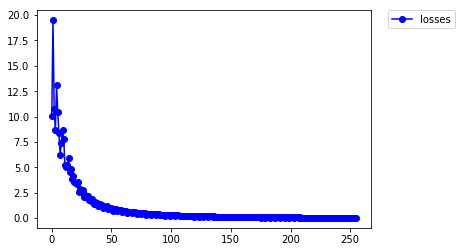

[64/100]
Train Accuracy 95.833333


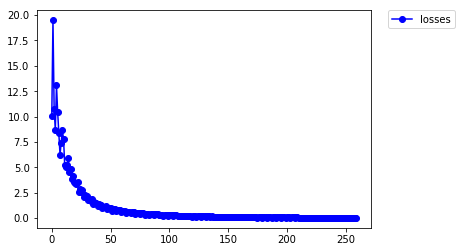

[65/100]
Train Accuracy 95.833333


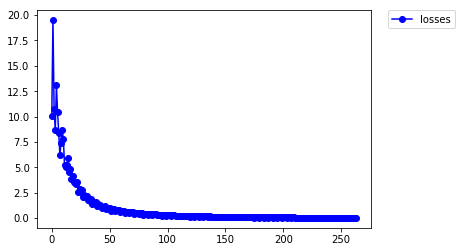

[66/100]
Train Accuracy 95.833333


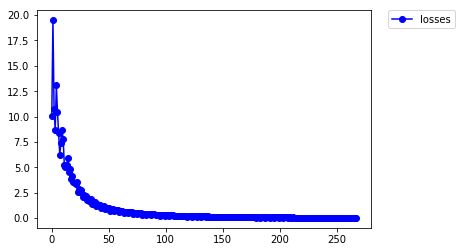

[67/100]
Train Accuracy 95.833333


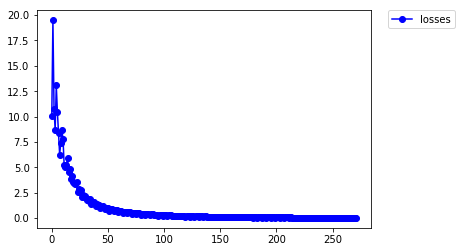

[68/100]
Train Accuracy 95.833333


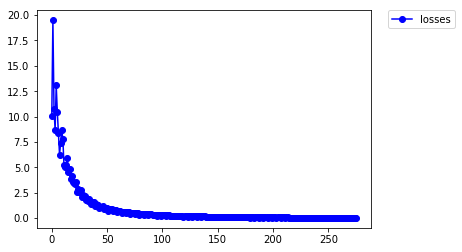

[69/100]
Train Accuracy 95.833333


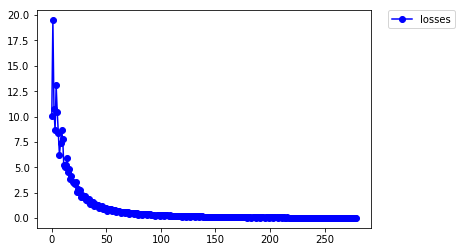

[70/100]
Train Accuracy 95.833333


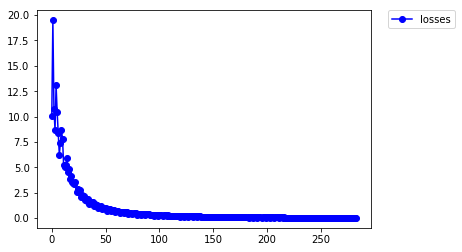

[71/100]
Train Accuracy 95.833333


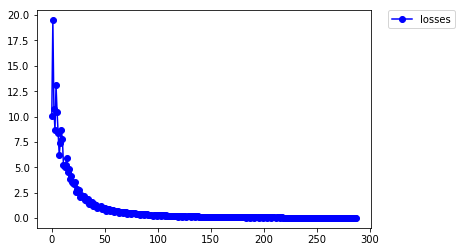

[72/100]
Train Accuracy 95.833333


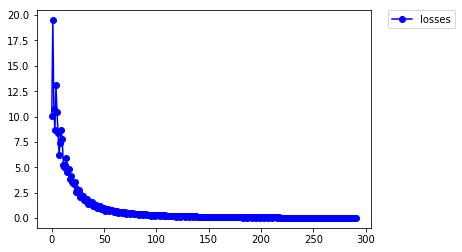

[73/100]
Train Accuracy 95.833333


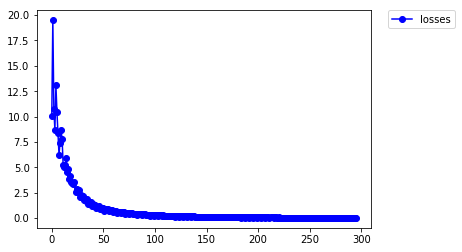

[74/100]
Train Accuracy 95.833333


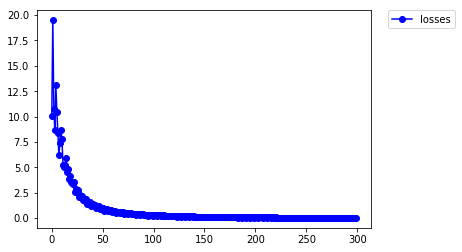

[75/100]
Train Accuracy 95.833333


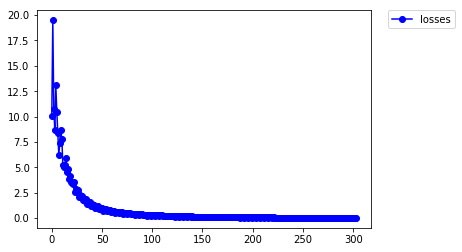

[76/100]
Train Accuracy 95.833333


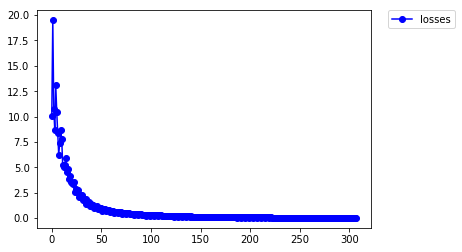

[77/100]
Train Accuracy 95.833333


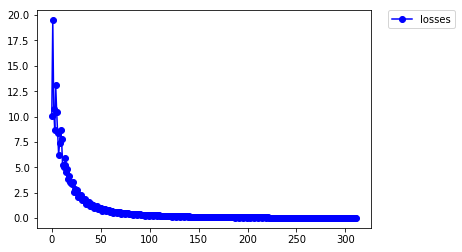

[78/100]
Train Accuracy 95.833333


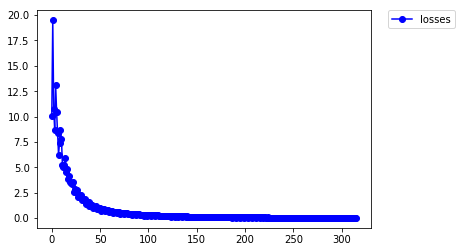

[79/100]
Train Accuracy 95.833333


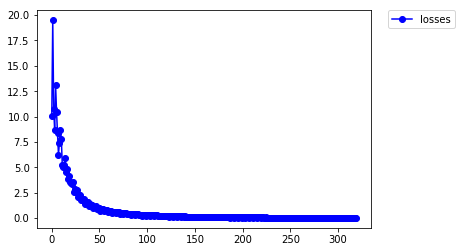

[80/100]
Train Accuracy 95.833333


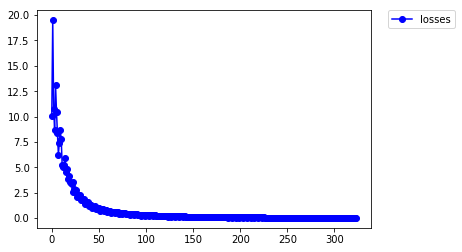

[81/100]
Train Accuracy 95.833333


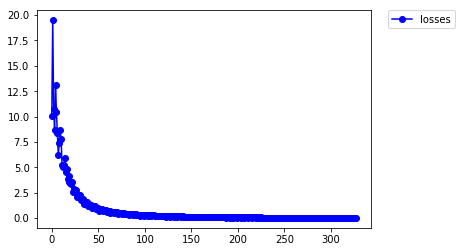

[82/100]
Train Accuracy 95.833333


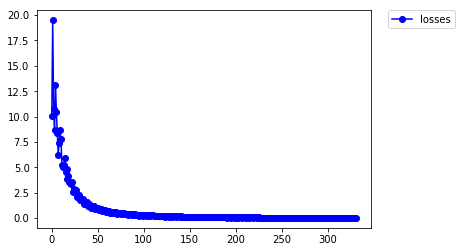

[83/100]
Train Accuracy 95.833333


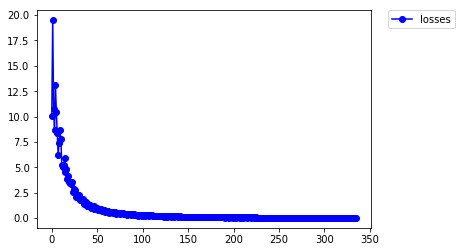

[84/100]
Train Accuracy 95.833333


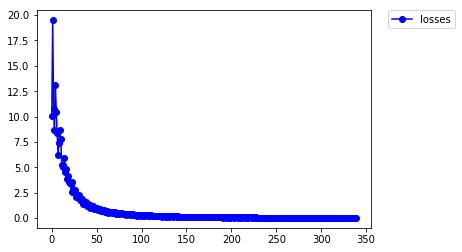

[85/100]
Train Accuracy 95.833333


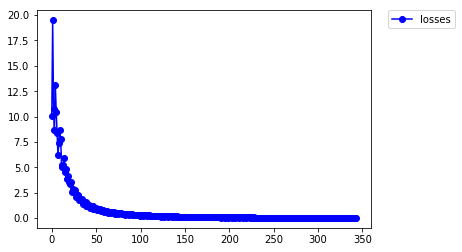

[86/100]
Train Accuracy 95.833333


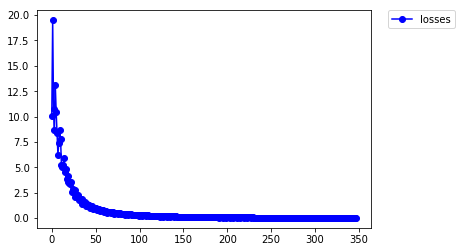

[87/100]
Train Accuracy 95.833333


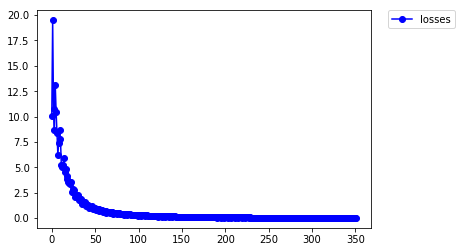

[88/100]
Train Accuracy 95.833333


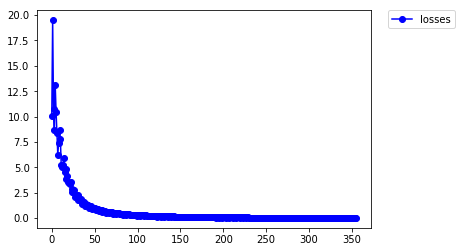

[89/100]
Train Accuracy 95.833333


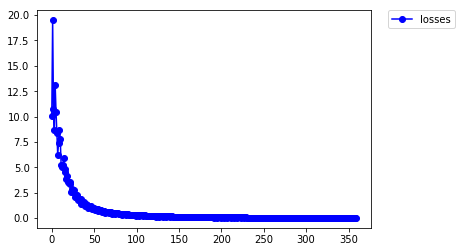

[90/100]
Train Accuracy 95.833333


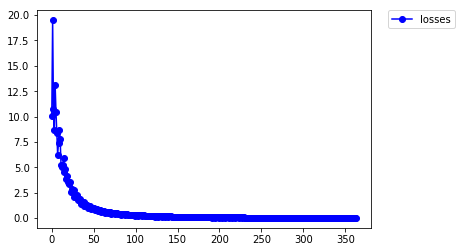

[91/100]
Train Accuracy 95.833333


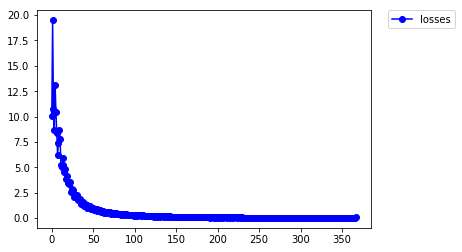

[92/100]
Train Accuracy 95.833333


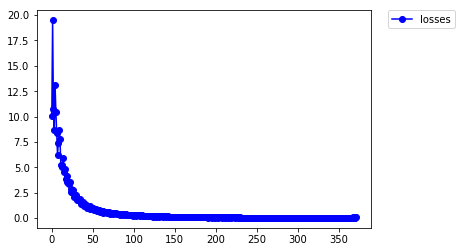

[93/100]
Train Accuracy 95.833333


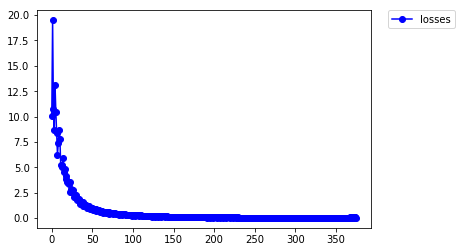

[94/100]
Train Accuracy 95.833333


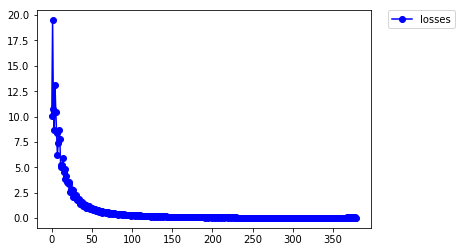

[95/100]
Train Accuracy 95.833333


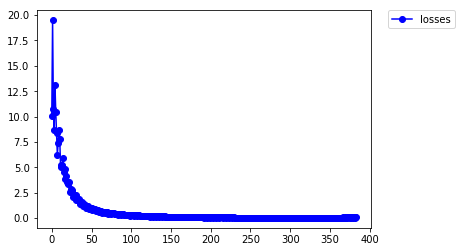

[96/100]
Train Accuracy 95.833333


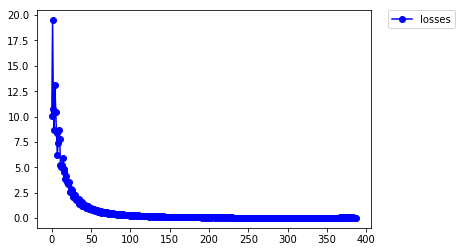

[97/100]
Train Accuracy 95.833333


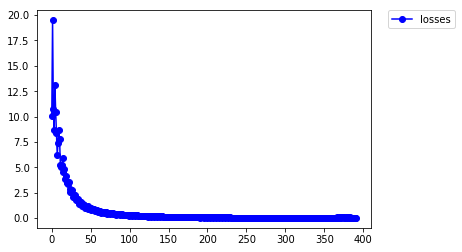

[98/100]
Train Accuracy 95.833333


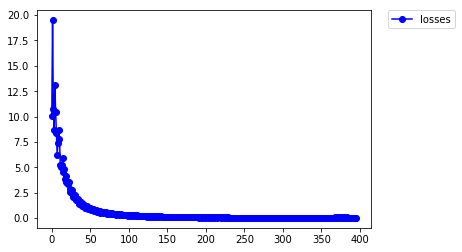

[99/100]
Train Accuracy 95.833333


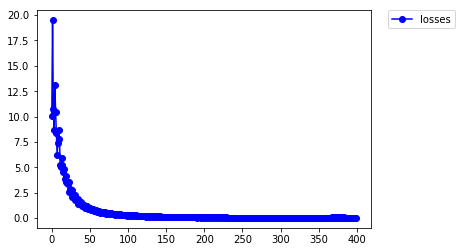

In [32]:
train_student(student, net2, testloader, optimizer_student, criterion, n_epochs=100, verbose=False)

Attack student with an attack we know works well on the student training/architecture. In this case we will use gradient ascent.


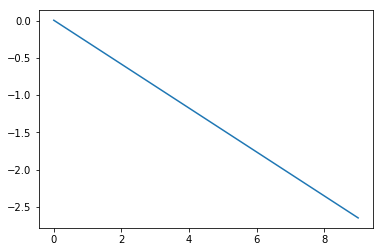

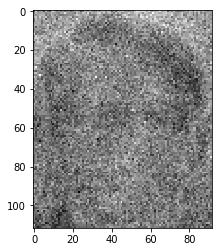

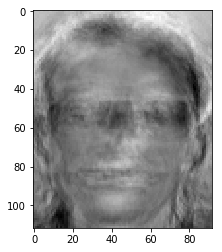

In [34]:
np_page=np.zeros((112,92))

dream_ga=ga(torch.Tensor((np_page)),student,10,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im_student.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [35]:
eval_target_net(net, testloader)


Accuracy = 92.50 %




92.5